AI ENVIRONMENTAL MONITORING


Model: LinearRegression
  Best Parameters: {}
  Best CV RMSE: 1.0831

Model: DecisionTreeRegressor
  Best Parameters: {'max_depth': 5}
  Best CV RMSE: 1.0887

Model: RandomForestRegressor
  Best Parameters: {'max_depth': 10, 'n_estimators': 100}
  Best CV RMSE: 1.0840
XGBoost Accuracy: 0.9863636363636363
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        21
           2       0.95      1.00      0.98        20
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        27
           5       1.00      1.00      1.00        17
           6       0.94      1.00      0.97        17
           7       1.00      1.00      1.00        14
           8       0.96      0.96      0.96        23
           9       1.00      1.00      1.00        20
          10       0.92      1.00      0.96        11
          11       1.00      0.95      0.98 

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:51:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


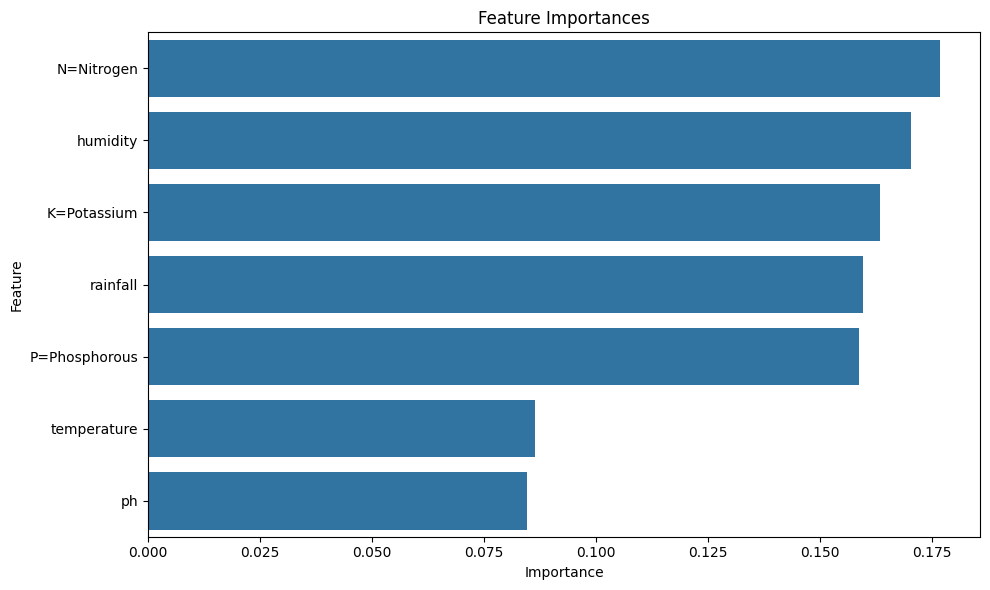


Best parameters for RandomForest: {'max_depth': None, 'n_estimators': 100}
Classification Report for RandomForest:
               precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       1.00      1.00      1.00        21
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        26
     coconut       1.00      1.00      1.00        27
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        17
      grapes       1.00      1.00      1.00        14
        jute       0.92      1.00      0.96        23
 kidneybeans       1.00      1.00      1.00        20
      lentil       0.92      1.00      0.96        11
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        19
   mothbeans       1.00      0.96      0.98        24
    mungbean       1.00      1.00      1.00        19
   muskmelon      

In [23]:
## IMPORTANT IMPORTANT
## MODEL IMPORTS 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

## EVALUATION IMPORTS
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

## TOOLS IMPORTS
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer


## LOAD DATA
pd4 = pd.read_csv('data/crop4.csv')
pd1 = pd.read_csv('data/cropclass.csv')

##GRID SEARCH PARAMETERS FOR MODELS--------------------------------------------------------------------------------------------------------------------
## REGRESSION MODELS
param_grid = {
    LinearRegression(): {}, 
    DecisionTreeRegressor(): {'max_depth': [None, 3, 5, 10]},
    RandomForestRegressor(): {'n_estimators': [50, 100], 'max_depth': [None, 10]}
}

## CLASSIFICATION MODELS
model_C = {
    "RandomForest": (RandomForestClassifier(), {
        'n_estimators': [50, 100],
        'max_depth': [None, 10, 20]
    }),
    "SVM": (SVC(), {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    }),
    "KNN": (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7]
    }),
    "LogisticRegression": (LogisticRegression(max_iter=1000), {
        'C': [0.1, 1, 10]
    })
}

# DATA PREPROCESSING FUNCTION---------------------------------------------------------------------------------------------------------------------
def preprocess_data(X_train, X_test):

    categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

    
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder( handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])
    
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    return X_train_processed, X_test_processed


# GRID SEARCH FUNCTION--------------------------------------------------------------------------------------------------------------------------

def grid_search(param_grid, X_train, y_train):
    model_performance = {}
    for model, params in param_grid.items():
        grid_search = GridSearchCV(estimator=model, param_grid=params, cv=3, scoring='neg_mean_squared_error',error_score='raise',n_jobs=-1)
        grid_search.fit(X_train, y_train)
        model_name = model.__class__.__name__
        model_performance[model_name] = {
                'best_params': grid_search.best_params_,
                'best_score': grid_search.best_score_,
                'best_model': grid_search.best_estimator_
        }
    return model_performance 

#FEATURE IMPORNTANCE FUNCTION--------------------------------------------------------------------------------------------------------------------
def feature_importance(model, feature_names, top_n=None):
    if hasattr(model, "feature_importances_"):
     importances = model.feature_importances_
  
    feat_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    if top_n:
        feat_imp_df = feat_imp_df.head(top_n)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
    plt.title('Feature Importances')
    plt.tight_layout()
    plt.show()


## YIELD PREDICTION - REGRESSION ---------------------------------------------------------------------------------------------------------------------
## OTHER USELESS FEATURES WERE DROPPED FROM THE DATASET
X1 = pd4.drop(['Yield_tons_per_hectare'], axis=1)
y1 = pd4['Yield_tons_per_hectare']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
x_pp,y_pp = preprocess_data(X1_train, X1_test)
grid_search_results = grid_search(param_grid, x_pp, y1_train)
for model_name, info in grid_search_results.items():
    rmse = np.sqrt(-info['best_score'])  # Convert neg MSE to RMSE
    print(f"\nModel: {model_name}")
    print(f"  Best Parameters: {info['best_params']}")
    print(f"  Best CV RMSE: {rmse:.4f}")

## CROP SELECTION - CLASSIFICATION ---------------------------------------------------------------------------------------------------------------------
# Load data
df = pd.read_csv("data/croprt.csv")

# Drop rows with missing values first
df = df.dropna()

# Define features and target
X = df.drop(['label'], axis=1)
y = df['label']


X = pd.get_dummies(X)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X2_train, X2_test, y2_train, y2_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X2_train, y2_train)


## Separate testing -----------------------------------------------------------------------------------------------------------------------------------
y_pred_xgb = xgb.predict(X2_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y2_test, y_pred_xgb))
feature_importance(xgb, X.columns)

best_models = {}
for name, (model, params) in model_C.items():
    grid = GridSearchCV(model, params, cv=3, scoring='accuracy',n_jobs=-1)
    grid.fit(X2_train, y2_train)
    y_pred = grid.best_estimator_.predict(X2_test)
    print(f"\nBest parameters for {name}: {grid.best_params_}")
    print(f"Classification Report for {name}:\n", classification_report(y2_test, y_pred, target_names=label_encoder.classes_))
    best_models[name] = grid.best_estimator_
    

    


In [18]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Load data
df = pd.read_csv("data/croprt.csv")

# Drop rows with missing values first
df = df.dropna()

# Encode target (Crop Type)
if 'label' in df.columns:
    crop_encoder = LabelEncoder()
    df['label'] = crop_encoder.fit_transform(df['label'])
else:
    raise KeyError("Column 'label' not found in the DataFrame after dropping missing values.")

# Define features and target
X = df.drop(['label'], axis=1)
y = df['label']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train XGBoost classifier----------------------------------------------------------------------------------
model = xgb.XGBClassifier(use_label_encoder=train_test_split, eval_metric='mlogloss', random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Model Accuracy: {accuracy * 100:.2f}%")

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



XGBoost Model Accuracy: 98.64%
Accuracy: 0.9931818181818182

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00        21
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        27
           5       1.00      1.00      1.00        17
           6       1.00      1.00      1.00        17
           7       1.00      1.00      1.00        14
           8       0.92      1.00      0.96        23
           9       1.00      1.00      1.00        20
          10       0.92      1.00      0.96        11
          11       1.00      1.00      1.00        21
          12       1.00      1.00      1.00        19
          13       1.00      0.96      0.98        24
          14       1.00      1.00      1.00        19
          15       1.00      1.00      1.00       

Accuracy: 0.99

Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       1.00      1.00      1.00        21
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        26
     coconut       1.00      1.00      1.00        27
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        17
      grapes       1.00      1.00      1.00        14
        jute       0.92      1.00      0.96        23
 kidneybeans       1.00      1.00      1.00        20
      lentil       0.92      1.00      0.96        11
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        19
   mothbeans       1.00      0.96      0.98        24
    mungbean       1.00      1.00      1.00        19
   muskmelon       1.00      1.00      1.00        17
      orange       1.00      1.00      1.0

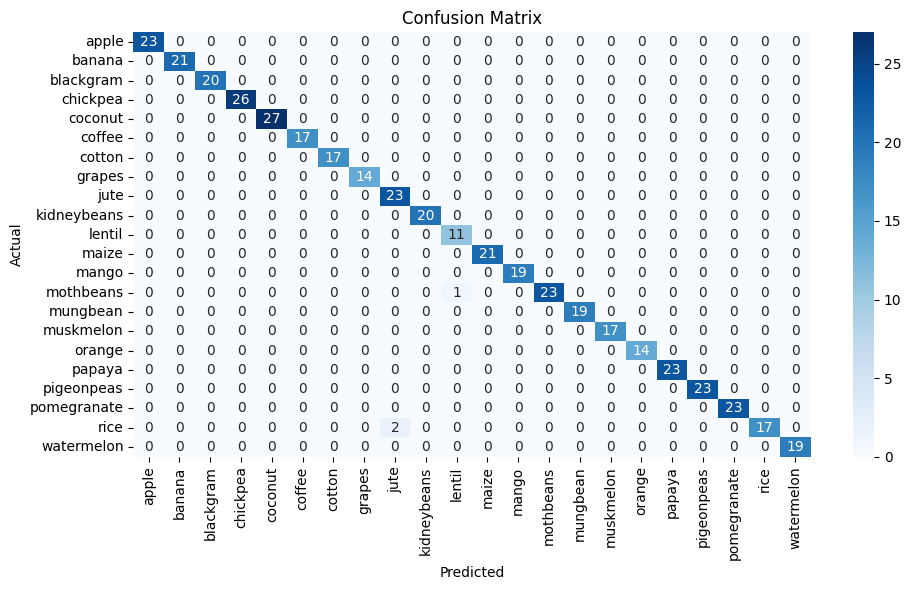

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


# Load data
df = pd.read_csv("data/croprt.csv")

# Drop rows with missing values first
df = df.dropna()

# Encode target (Crop Type)
if 'label' in df.columns:
    crop_encoder = LabelEncoder()
    df['label'] = crop_encoder.fit_transform(df['label'])
else:
    raise KeyError("Column 'label' not found in the DataFrame after dropping missing values.")

# Define features and target
X = df.drop(['label'], axis=1)
y = df['label']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=crop_encoder.classes_))

# Confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=crop_encoder.classes_,
            yticklabels=crop_encoder.classes_,
            cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
